In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-06-23 09:56:22--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  29.9MB/s    in 20s     

2020-06-23 09:56:43 (20.8 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
!unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!mv Food-5K/* .

In [7]:
!ls training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

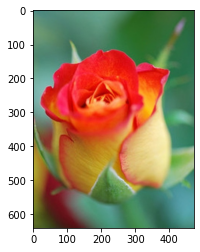

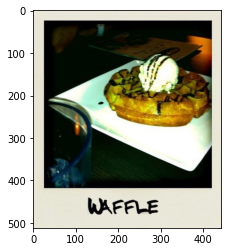

In [8]:
plt.figure(1)
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

plt.figure(2)
plt.imshow(image.load_img('training/1_22.jpg'))
plt.show()

In [9]:
!mkdir data

In [10]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [11]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [12]:
train_path = 'data/train'
valid_path = 'data/test'

In [13]:
IMAGE_SIZE = [200, 200]

In [14]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [15]:
folders = glob(train_path + '/*')
print('folders:', folders)

folders: ['data/train/nonfood', 'data/train/food']


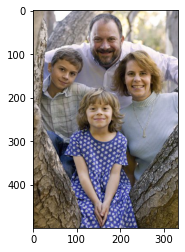

In [16]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [17]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
x = Flatten()(ptm.output)
print('x.shape:', x.shape)

x.shape: (None, 18432)


In [19]:
model = Model(inputs=ptm.input, outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [21]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [22]:
batch_size = 128

train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

print('D.shape:', D)

D.shape: 18432


In [24]:
print('feat.shape:', feat.shape)

feat.shape: (1, 18432)


In [25]:
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros((Ntrain))
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros((Nvalid))

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_valid.shape:', X_valid.shape)
print('Y_valid.shape:', Y_valid.shape)

X_train.shape: (3000, 18432)
Y_train.shape: (3000,)
X_valid.shape: (1000, 18432)
Y_valid.shape: (1000,)


In [26]:
i = 0
for x, y in train_generator:
  # Getting features
  features = model.predict(x)

  # Getting size of the batch 
  sz = len(y)

  # Assigning X_train, Y_train
  X_train[i:i+sz] = features
  Y_train[i:i+sz] = y

  #incrementing i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [27]:
i = 0
for x, y in valid_generator:
  features = model.predict(x)
  sz = len(y)

  X_valid[i:i+sz] = features
  Y_valid[i:i+sz] = y

  i += sz

  if i >= Nvalid:
    print('breaking now')
    break

print(i)


breaking now
1000


In [28]:
print(' X_train.max():', X_train.max(), '\n', 'X_train.min():', X_train.min())

 X_train.max(): 650.8261108398438 
 X_train.min(): 0.0


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2 = scaler.fit_transform(X_train)
X_valid_2 = scaler.transform(X_valid)

In [30]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train_2, Y_train)
print(logr.score(X_train_2, Y_train))
print(logr.score(X_valid_2, Y_valid))

1.0
0.979


In [31]:
# Autoregressive model - logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [32]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [33]:
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_valid, Y_valid)
)

Epoch 1/10
24/24 [==============================] - 0s 18ms/step - loss: 0.9578 - accuracy: 0.9313 - val_loss: 0.3519 - val_accuracy: 0.9780
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0501 - accuracy: 0.9943 - val_loss: 0.3247 - val_accuracy: 0.9800
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.9983 - val_loss: 0.3808 - val_accuracy: 0.9800
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 4.5988e-06 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.9790
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 3.3390e-06 - accuracy: 1.0000 - val_loss: 0.3479 - val_accuracy: 0.9790
Epoch 6/10
24/24 [==============================] - 0s 12ms/step - loss: 2.7999e-06 - accuracy: 1.0000 - val_loss: 0.3479 - val_accuracy: 0.9790
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 2.4755e-06 - accuracy: 1.0000 - val_loss: 0.3481 - val_accuracy: 0.97

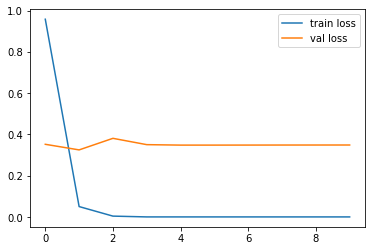

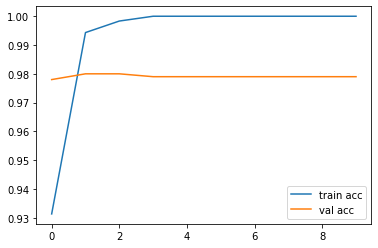

In [34]:
# Plotting loss and accuracy
plt.figure(1)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()